In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [111]:
def to_hours(time):
    return (time // 3600) + 6

def clean_sales_data():
    df = pd.read_csv("../assets/example_data/sales_data.csv")
    sales_df = df[['token_id', 'sold_at', 'price']]
    sales_df = sales_df.rename(columns={'token_id': 'horse_id', 'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
    sales_df['timestamp'] = sales_df['time_sold'].apply(to_hours)

    return sales_df

In [112]:
sales_data = clean_sales_data()

In [113]:
eth_prices = pd.read_csv('../assets/eth_price_history.csv')
eth_prices.tail()

,Unnamed: 0,timestamp,eth_price
9091,9091,464923,1533.01
9092,9092,464924,1529.65
9093,9093,464925,1535.38
9094,9094,464926,1538.76
9095,9095,464927,1550.97


In [114]:
merged = pd.merge(sales_data, eth_prices, left_on='timestamp', right_on='timestamp', how='left')
merged['converted_price'] = merged['price'] * merged['eth_price']
clean_market_data = merged.drop(columns=['Unnamed: 0', 'price', 'timestamp','eth_price'])
clean_market_data.shape

def to_day(unix_time):
    return datetime.date.fromtimestamp(unix_time)

clean_market_data['day_sold'] = clean_market_data['time_sold'].apply(to_day)
clean_market_data

,horse_id,time_sold,converted_price,day_sold
0,27,1650124789,60665.000,2022-04-16
1,68,1657313128,13934.205,2022-07-08
2,75,1657313072,9693.360,2022-07-08
3,89,1657313100,9693.360,2022-07-08
4,92,1663112422,10943.775,2022-09-13
...,...,...,...,...
74906,520344,1673482196,139.492,2023-01-11
74907,520345,1673514341,138.079,2023-01-12
74908,520346,1673487400,139.884,2023-01-11
74909,520404,1673622818,499.436,2023-01-13


### Deal with outliers

In [115]:
# Calculate the z-score for each data point
clean_market_data['z_score'] = np.abs((clean_market_data['converted_price'] - np.mean(clean_market_data['converted_price'])) / np.std(clean_market_data['converted_price']))

clean_market_data
market_data_no_outliers = clean_market_data[clean_market_data['z_score'] < 3]
print(clean_market_data.shape, market_data_no_outliers.shape, f'=> {74911 - 74820} data points removed')

(74911, 5) (74820, 5) => 91 data points removed


In [116]:
# horse data cleaning
horse_data = pd.read_csv('../assets/all_horse_meta_oliver.csv')
horse_data.columns
horse_data = horse_data.rename(columns={'data.horse.bloodline':'bloodline', 'data.horse.breed_type':'breed_type',
                           'data.horse.breeding_counter':'breeding_counter', 'data.horse.color':'horse_color',
                           'data.horse.horse_type':'horse_type', 'data.horse.img_url':'img_url',
                           'data.horse.last_breeding_reset':'last_breeding_reset', 'data.horse.name':'horse_name',
                           'data.horse.nft_id':'nft_id', 'data_horse_offsprings':'offsprings',
                           'data.horse.race_statistic.first_place_finishes':'first_place_finishes',
                           'data.horse.race_statistic.number_of_races':'number_races',
       'data.horse.race_statistic.second_place_finishes':'second_place_finishes',
       'data.horse.race_statistic.third_place_finishes':'third_place_finishes',
       'data.horse.race_statistic.win_rate':'win_rate',
                                        'data.horse.gen':'genotype'})
horse_data = horse_data.drop(columns=['Unnamed: 0'])
# print(horse_data.nft_id)
horse_data.head()

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat
0,Buterin,genesis,Anti-Flash White,Z9,Mare,https://img.zed.run/horses/F2F3F4.png,2021-07-09T15:47:37,Sneaky Flirt,42102,[],8,4.60,174,53,227,0.0,15,16,3.52,False
1,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],17,5.03,318,20,338,5.0,25,35,5.03,False
2,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",0,0.00,12,0,12,0.0,0,0,0.00,False
3,Buterin,pacer,Ghost White,Z268,Stallion,https://img.zed.run/horses/FFFFFF.png,2022-06-29T07:34:16,King Crew,435325,"[{'name': 'King Gerardo', 'nft_id': 416984}, {...",0,0.00,7,0,7,0.0,0,0,0.00,False
4,Buterin,pacer,Antique White,Z268,Filly,https://img.zed.run/horses/FAEBD7.png,2022-06-29T07:35:25,Queen Iliana,435326,"[{'name': 'Z268 White Smoke IV', 'nft_id': 382...",0,0.00,20,0,20,0.0,0,1,0.00,False


In [117]:
# code to merge horse data with sales data
test_merge = pd.merge(horse_data,market_data_no_outliers, right_on='horse_id', left_on='nft_id', how='left')
test_merge

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,...,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,day_sold,z_score
0,Buterin,genesis,Anti-Flash White,Z9,Mare,https://img.zed.run/horses/F2F3F4.png,2021-07-09T15:47:37,Sneaky Flirt,42102,[],...,0.0,15,16,3.52,False,42102,1672835547,86.945520,2023-01-04,0.025410
1,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],...,5.0,25,35,5.03,False,42104,1669887682,102.400000,2022-12-01,0.025328
2,Buterin,genesis,Shadow Fighter,Z9,Mare,https://img.zed.run/horses/BFAFB2.png,2021-07-09T15:47:35,Master Of Irony,42104,[],...,5.0,25,35,5.03,False,42104,1669113231,73.711300,2022-11-22,0.025480
3,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",...,0.0,0,0,0.00,False,435320,1658538888,10.752347,2022-07-22,0.025814
4,Buterin,pacer,Caribbean Green,Z268,Colt,https://img.zed.run/horses/00CC99.png,2022-06-29T07:32:05,King Casen,435320,"[{'name': 'Z268 Midnight Black XV', 'nft_id': ...",...,0.0,0,0,0.00,False,435320,1660521631,4.137903,2022-08-14,0.025849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,Szabo,exclusive,Hairy Canary,Z7,Mare,https://img.zed.run/horses/FFFF99.png,2021-12-25T14:06:44,Lucky Airdrop,174107,"[{'name': 'Carrot Breath', 'nft_id': 93451}, {...",...,12.0,52,34,11.80,False,174107,1672718381,26.735720,2023-01-02,0.025729
539,Nakamoto,exclusive,Electric Violet,Z6,Mare,https://img.zed.run/horses/8F00FF.png,2021-12-25T14:18:07,Mona Lisa Vito,174112,"[{'name': 'Queen of Alpine', 'nft_id': 122277}...",...,0.0,27,34,3.07,False,174112,1650776977,103.157250,2022-04-24,0.025324
540,Nakamoto,exclusive,Electric Violet,Z6,Mare,https://img.zed.run/horses/8F00FF.png,2021-12-25T14:18:07,Mona Lisa Vito,174112,"[{'name': 'Queen of Alpine', 'nft_id': 122277}...",...,0.0,27,34,3.07,False,174112,1649736951,90.783900,2022-04-11,0.025390
541,Nakamoto,exclusive,Electric Violet,Z6,Mare,https://img.zed.run/horses/8F00FF.png,2021-12-25T14:18:07,Mona Lisa Vito,174112,"[{'name': 'Queen of Alpine', 'nft_id': 122277}...",...,0.0,27,34,3.07,False,174112,1653203646,66.829950,2022-05-22,0.025516


## Exploratory Data Analysis

### Price Distribution

<AxesSubplot: xlabel='converted_price'>

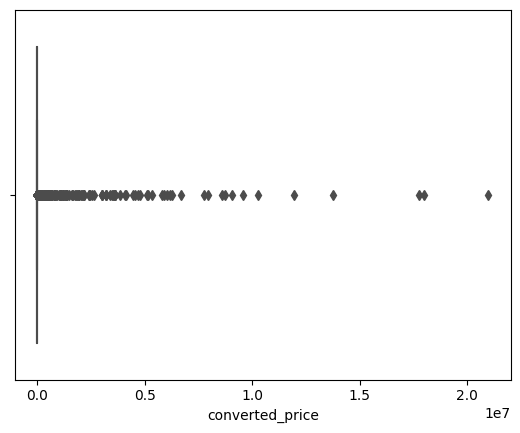

In [118]:
sns.boxplot(data = clean_market_data, x='converted_price', color='red')
# plt.xlim(0,20000)
# plt.ylim(0,80)

The distribution of prices is highly right skewed.

### Win rate vs Price

<AxesSubplot: xlabel='win_rate', ylabel='converted_price'>

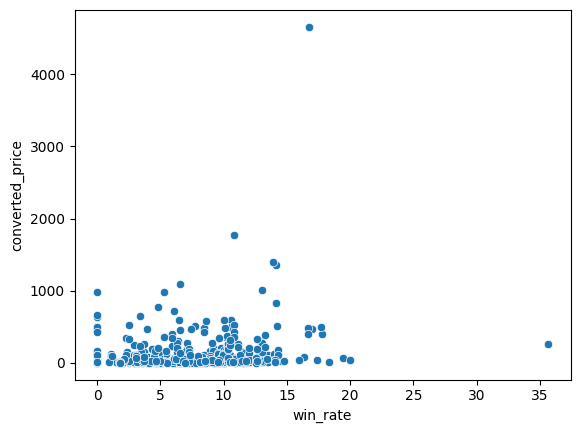

In [119]:
sns.scatterplot(data=test_merge, x='win_rate', y='converted_price')

### Different Factors by Breed

In [120]:
by_breed = test_merge.groupby('breed_type').mean().reset_index()
by_breed

/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_6343/2082808561.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_breed = test_merge.groupby('breed_type').mean().reset_index()


,breed_type,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,cross,404892.450980,12.549020,5.943333,123.254902,4.019608,127.274510,1.515098,11.862745,9.509804,5.772941,0.000000,404892.450980,1.661050e+09,20.158179,0.025764
1,elite,400478.282051,15.679487,7.485128,137.641026,44.012821,181.653846,3.469231,16.692308,17.153846,7.052051,0.038462,400478.282051,1.660029e+09,28.983156,0.025717
2,exclusive,351971.523256,18.412791,7.610058,178.308140,34.901163,213.209302,3.286453,18.645349,18.279070,7.108953,0.005814,351971.523256,1.660973e+09,49.661982,0.025607
3,genesis,42608.567010,18.092784,7.132990,208.494845,41.185567,249.680412,2.911031,20.350515,21.206186,6.052577,0.000000,42608.567010,1.661764e+09,272.963889,0.024424
4,legendary,317840.480000,30.210000,7.975200,275.070000,71.910000,346.980000,2.829700,30.850000,28.800000,7.410100,0.010000,317840.480000,1.659504e+09,203.912917,0.024790
5,pacer,421121.911111,3.155556,2.950000,49.400000,4.844444,54.244444,2.200889,3.800000,4.511111,2.954667,0.044444,421121.911111,1.660206e+09,33.710851,0.025692


Text(0.5, 1.0, 'Mean Win Rate by Breed Type')

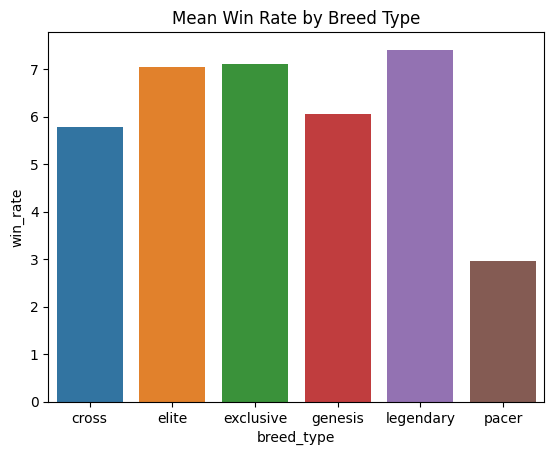

In [121]:
sns.barplot(data=by_breed, x='breed_type', y='win_rate')
plt.title('Mean Win Rate by Breed Type')

Text(0.5, 1.0, 'Mean Number of 1st Place Finishes by Breed')

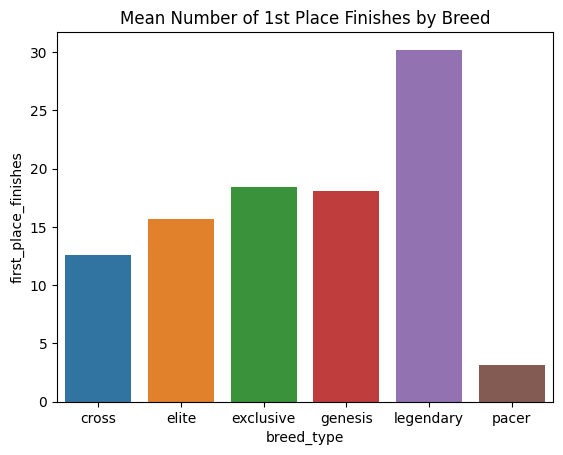

In [122]:
sns.barplot(data=by_breed, x='breed_type', y='first_place_finishes')
plt.title('Mean Number of 1st Place Finishes by Breed')

<AxesSubplot: xlabel='breed_type', ylabel='converted_price'>

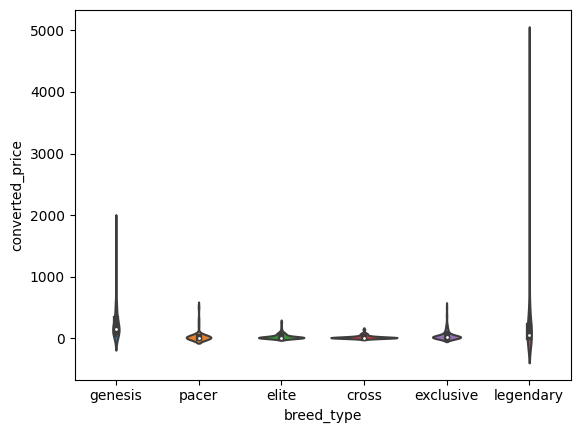

In [123]:
sns.violinplot(data=test_merge, x='breed_type', y='converted_price')

### Different Factors by Bloodline

In [124]:
by_blood = test_merge.groupby('bloodline').mean().reset_index()
by_blood

/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_6343/1323334638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_blood = test_merge.groupby('bloodline').mean().reset_index()


,bloodline,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,Buterin,242488.905724,18.575758,6.595051,173.202020,37.956229,211.158249,2.699562,18.023569,16.717172,6.015758,0.010101,242488.905724,1.660508e+09,109.355854,0.025291
1,Finney,391547.437500,11.225000,6.906500,126.800000,11.175000,137.975000,2.869375,11.900000,12.225000,6.637750,0.050000,391547.437500,1.659613e+09,21.643906,0.025756
2,Nakamoto,389116.720339,23.813559,8.077966,236.491525,64.135593,300.627119,3.628983,26.847458,27.940678,7.393814,0.000000,389116.720339,1.661534e+09,202.575896,0.024797
3,Szabo,375723.229167,15.062500,7.366667,169.875000,27.291667,197.166667,2.457917,18.145833,18.062500,7.044167,0.000000,375723.229167,1.661106e+09,43.796550,0.025639


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Buterin'),
  Text(1, 0, 'Finney'),
  Text(2, 0, 'Nakamoto'),
  Text(3, 0, 'Szabo')])

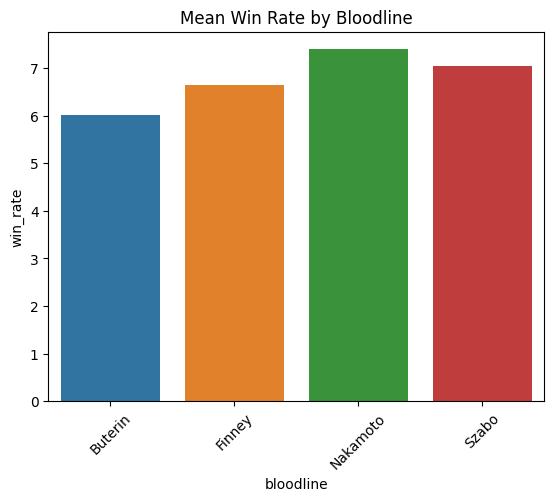

In [125]:
sns.barplot(data=by_blood, x='bloodline', y='win_rate')
plt.title('Mean Win Rate by Bloodline')
plt.xticks(rotation = 45)

<AxesSubplot: xlabel='day_sold', ylabel='converted_price'>

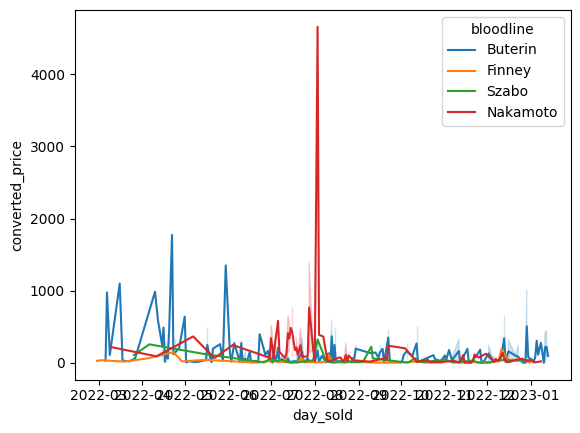

In [126]:
sns.lineplot(data=test_merge, x='day_sold', y='converted_price', hue= 'bloodline')